# 1D RDME simulation to determine cell polarization via a signalling pathway
nicole pagane
10/24/17

### import necessary modules

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.integrate as snt
import scipy.stats as stats
from scipy.optimize import curve_fit

### parameters

In [2]:
# temperature
T = 295 #K

#viscosity of solution
eta = 1e-3 #Pa*s

#radius of substrate (assume the kinase is the same similar size)
r = 1e-9 #m

#one-dimensional length of lattice gradient
L = 1.0e-3 #m

#number of compartments **INCLUDING THE 2 CONSTANT BOUNDARY SUBVOLUMES AND 3 CENTRAL SUBVOLUMES OF THE CELL**
K = 9

#iterations of the gillepsie algorithm
n = 100000

#how many runs to stochasticly simulate to get overall distribution
Sim = 50

#original far left and far right compartment species numbers
N = {}
N['A'] = np.asarray([50, 200])

#initial number of kinase molecules
c2 = 100

#initial number of singly phosphoylated kinase molecules
c3 = 0

#initial number of doubly phosphorylated kinase molecules
c4 = 0

### define equations and constants for RDME simulation to establish the gradient 

In [3]:
#boltzmann constant
Kb = 1.38e-23 #J/K

# diffusion constant for substrate, assuming the kinase and phosphorylated kinase have the same D
D = (Kb*T)/(6*np.pi*eta*r)
N['D'] = D
N['L'] = L
N['K'] = K

# gillespie with constant boundary concentrations
def gillespieBoundary(N, n):
    L = N['L']
    K = N['K']
    D = N['D']
    h = L/K
    d = D/(h**2)
    tt = 0
    x = np.zeros(K)
    x[1:K-1] = np.random.randint(min(N['A'][0], N['A'][1]),max(N['A'][0], N['A'][1]),K-2)
    x[0] = N['A'][0]
    x[-1] = N['A'][1]
    Ntot = np.sum(x)
    tvec = np.zeros(n)
    xmat = np.matrix(np.zeros([n+1,K]))
    xmat[0,:] = x
    for i in range(0,n):
        a = x*d
        Ntot = np.sum(x)
        a0 = 2*d*Ntot - d*x[0] - d*x[-1]
        tt = tt + np.random.exponential(1/a0,1)
        rand = np.random.random()
        if rand < np.sum(a[0:K-1])/a0:
            # j from 0 to K-1
            for j in range(0,K-1):
                if rand >= np.sum(a[0:j])/a0 and rand < np.sum(a[0:j+1])/a0:
                    break
            x[j] = x[j] - 1
            x[j+1] = x[j+1] + 1
            x[0:j-1] = x[0:j-1]
            x[j+2:] = x[j+2:]
        if rand >= np.sum(a[0:K-1])/a0:
            # j from 1 to K
            for j in range(1,K):
                if rand >= (np.sum(a[0:K-1]) + np.sum(a[1:j]))/a0 and rand < (np.sum(a[0:K-1]) + np.sum(a[1:j+1]))/a0:
                    break
            x[j] = x[j] - 1
            x[j-1] = x[j-1] + 1
            x[0:j-2] = x[0:j-2]
            x[j+1:] = x[j+1:]
        tvec[i] = tt
        x[0] = N['A'][0]
        x[-1] = N['A'][1]
        xmat[i+1,:] = x
    return np.asarray([tvec, xmat])

### run RDME simulation 

In [4]:
#run simulations in isolated cell to avoid running multiple times 
out = {}
for i in range(0,Sim):
    out[i] = gillespieBoundary(N, n)
print('simulations complete')

simulations complete


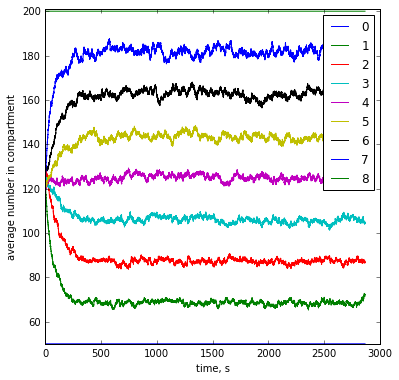

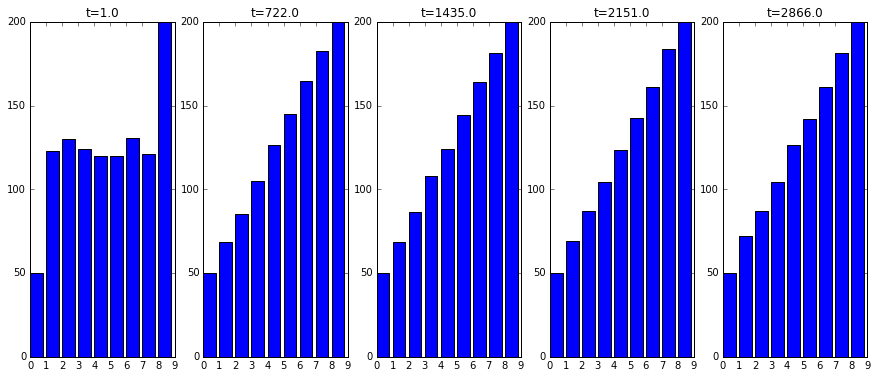

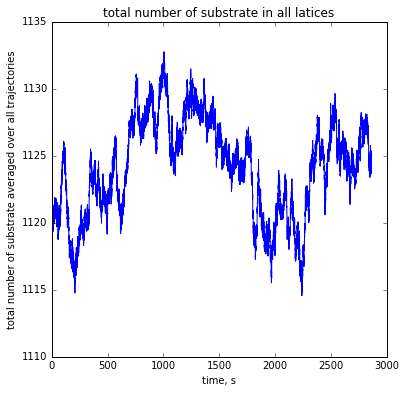

In [5]:
#plot here to avoid having to run the simulations again
timemeans = np.zeros(n)
runmeans = np.zeros([n+1,K])
for i in range(0,Sim):
    timemeans += out[i][0]
    runmeans += out[i][1]
    
timemeans = timemeans/Sim
runmeans = runmeans/Sim

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.plot(timemeans, runmeans[0:n])
ax.set_xlabel('time, s')
ax.set_ylabel('average number in compartment')
ax.set_ylim([min(N['A'][0], N['A'][1]), max(N['A'][0], N['A'][1])+1])
ax.legend(''.join(np.asarray(np.linspace(0, K-1, K, dtype = 'int'), dtype='string')))

pltnum = 5
fig = plt.figure(figsize=(15,6))
for i in range(0, pltnum):
    ind = int(np.linspace(0, n-1, pltnum)[i])
    ax = fig.add_subplot(1,pltnum,i+1)
    ax.bar(range(K),runmeans[ind], align='edge')
    plt.title(''.join(['t=', str(np.ceil(timemeans[ind]))]))

# plot number of molecules per time
fig = plt.figure(figsize=(6,6))
ax = fig.gca()

#get the left membrance concetration average
subConc = np.zeros(n).reshape([n,1])
for i in range(0, Sim):
    subConc += np.asarray(np.sum(out[i][1],1))[0:n]
    
subConc = subConc/Sim

ax.plot(timemeans, subConc)
ax.set_title('total number of substrate in all latices')
ax.set_xlabel('time, s')
ax.set_ylabel('total number of substrate averaged over all trajectories')

plt.show()

### deterministically solve cell signalling pathway equations

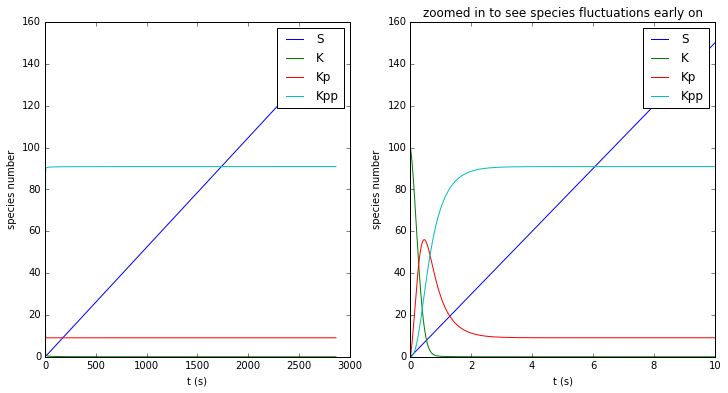

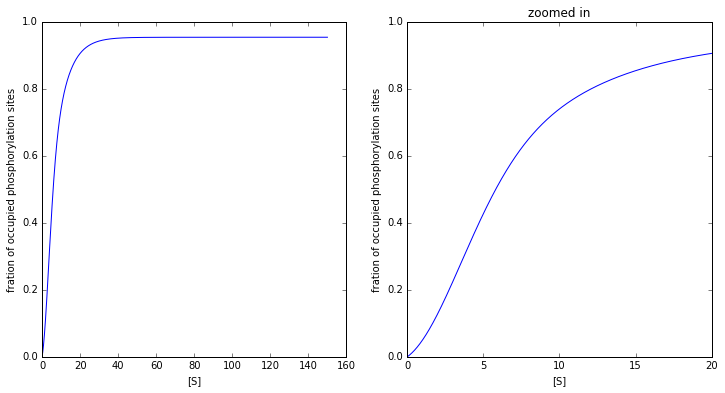

In [17]:
## SPECIES ###
# S    substrate                        (c1)
# K    kinase                           (c2)
# Kp   phosphorylated kinase            (c3)
# Kpp  doubly phosphorlyated kinase     (c4)

### EQUATIONS FOR CELL SIGNALLING ###
# S + K -> S + Kp  (k1)
#     K -> Kp      (k2)
#    Kp -> K       (k3)
#    Kp -> Kpp     (k4)
#   Kpp -> Kp      (k5)


# define intital values and parameters for the above kinetic rate laws
# model the concentration of substrate as a linear gradient 
c1 = 0# technically N['A'][0] is the correct initial concentration if looking at the boundary
     # but lets assume 0 for the next right cell 
y0 = [c1, c2, c3, c4] #initial species number
k1 = 1
k2 = 1
k3 = .1
k4 = 2
k5 = .2
ti = 0
tf = timemeans[n-1]
#tf = 10
t = np.linspace(ti, tf, n)

# define rates equations
def rates(y, t):
    return np.asarray([(N['A'][1] - N['A'][0])/tf, 
                      -k1*y[0]*y[1] - k2*y[1] + k3*y[2],
                      k1*y[0]*y[1] + k2*y[1] - k3*y[2] - k4*y[2] + k5*y[3],
                      k4*y[2] -  k5*y[3]])

# solve the ODEs
ode = snt.odeint(rates, y0,t)

# plot species
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
for i in range(len(y0)):
    ax.plot(t, ode[:,i][0:n])
ax.set_xlabel('t (s)')
#plt.title(''.join(['[S] = ', str(c1)]))
ax.set_ylabel('species number')
ax.legend(['S', 'K', 'Kp', 'Kpp'])

#zoom in 
ax = fig.add_subplot(1,2,2)
tf = 10
t = np.linspace(ti, tf, n)
ode = snt.odeint(rates, y0,t)
for i in range(len(y0)):
    ax.plot(t, ode[:,i][0:n])
ax.set_xlabel('t (s)')
ax.set_title('zoomed in to see species fluctuations early on')
ax.set_ylabel('species number')
ax.legend(['S', 'K', 'Kp', 'Kpp'])
ax.set_xlim([0,10])

#plot fration of occupied phosphorylation sites to determine of parameters yield cooperativity 
# (sigmoidal as opposed to hyperbolic)
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
ax.plot(ode[:,0], (ode[:,2] + 2*ode[:,3])/(2*(ode[:,1] + ode[:,2] + ode[:,3])))
ax.set_ylabel('fration of occupied phosphorylation sites')
ax.set_xlabel('[S]')
ax = fig.add_subplot(1,2,2)
ax.plot(ode[:,0], (ode[:,2] + 2*ode[:,3])/(2*(ode[:,1] + ode[:,2] + ode[:,3])))
ax.set_ylabel('fration of occupied phosphorylation sites')
ax.set_xlabel('[S]')
plt.title('zoomed in')
ax.set_xlim([0, 20])

plt.show()

Hill constant, n: 1.50120240774
Dissociation constant, kD: 12.9072687071


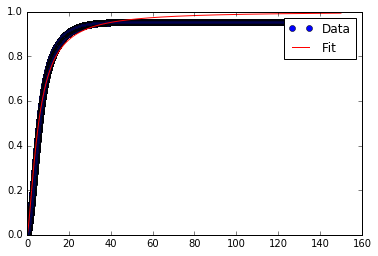

In [35]:
# Hill equation
def Hill(x, n , kD):
    return (x**n)/(kD + x**n)

# It will still try to guess parameters, but they are dumb!
popt, pcov = curve_fit(Hill, ode[:,0],(ode[:,2] + 2*ode[:,3])/(2*(ode[:,1] + ode[:,2] + ode[:,3])))
plot(ode[:,0],(ode[:,2] + 2*ode[:,3])/(2*(ode[:,1] + ode[:,2] + ode[:,3])), 'o', label='Data')
plot(ode[:,0],Hill(ode[:,0], popt[0], popt[1]), 'r-', label='Fit')
legend()
print(''.join(['Hill constant, n: ', str(popt[0]), '\n', 'Dissociation constant, kD: ', str(popt[1])]))
plt.show()

### plot the differentials of the species by the substrate concentration

In [37]:
#find dkpp/dt
dkpp = np.diff(ode[:,3])/np.diff(t)

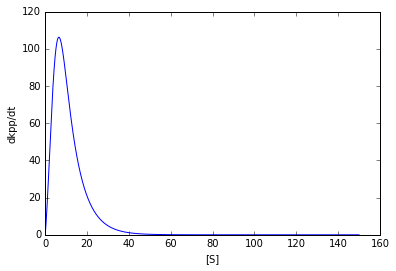

In [38]:
plt.plot(ode[:,0][0:n-1],dkpp)
plt.xlabel('[S]')
plt.ylabel('dkpp/dt')
plt.show()